In [1]:
!pip install transformers datasets seqeval torch accelerate numpy


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import json
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
import numpy as np


SyntaxError: invalid syntax (2328072701.py, line 3)

In [180]:
import json
from datasets import Dataset


with open("datasets/complete/fixed_output.json", "r", encoding="utf-8") as f:
    data = json.load(f)
with open("datasets/complete/ner_most_alerted_location_dataset.json", "r") as f:
    ner_data = json.load(f)
data = data + ner_data
print(len(data))
data



429


[{'tokens': ['How',
   'many',
   'red',
   'alerts',
   'where',
   'there',
   'in',
   "Zru'a",
   '?'],
  'ner_tags': ['O',
   'O',
   'B-ALERT_TYPE',
   'I-ALERT_TYPE',
   'O',
   'O',
   'O',
   'B-LOCATION',
   'O']},
 {'tokens': ['Were',
   'there',
   'rocket',
   'alerts',
   'in',
   'Kfar',
   'Vitkin',
   'last',
   'week',
   '?'],
  'ner_tags': ['O',
   'O',
   'B-ALERT_TYPE',
   'I-ALERT_TYPE',
   'O',
   'B-LOCATION',
   'I-LOCATION',
   'B-TIME_FRAME',
   'I-TIME_FRAME',
   'O']},
 {'tokens': ['How',
   'many',
   'rocket',
   'alerts',
   'where',
   'there',
   'in',
   'Tuval',
   '?'],
  'ner_tags': ['O',
   'O',
   'B-ALERT_TYPE',
   'I-ALERT_TYPE',
   'O',
   'O',
   'O',
   'B-LOCATION',
   'O']},
 {'tokens': ['Has',
   'there',
   'been',
   'any',
   'red',
   'alerts',
   'in',
   'the',
   'past',
   '24',
   'hours',
   '?'],
  'ner_tags': ['O',
   'O',
   'O',
   'O',
   'B-ALERT_TYPE',
   'I-ALERT_TYPE',
   'O',
   'O',
   'B-TIME_FRAME',
   'I-TIME_FRAM

In [181]:
unique_tags = list(set(tag for sample in data for tag in sample["ner_tags"]))
print(unique_tags)  


label2id = {label: i for i, label in enumerate(unique_tags)}
id2label = {i: label for label, i in label2id.items()}
label_list = list(label2id.keys())
print(label2id) 

for sample in data:
    sample["ner_tags"] = [label2id[label] for label in sample["ner_tags"]]
print(data[300])




['O', 'B-LOCATION', 'B-TIME_FRAME', 'I-DATE', 'B-ALERT_TYPE', 'I-TIME_FRAME', 'I-LOCATION', 'I-ALERT_TYPE', 'B-DATE']
{'O': 0, 'B-LOCATION': 1, 'B-TIME_FRAME': 2, 'I-DATE': 3, 'B-ALERT_TYPE': 4, 'I-TIME_FRAME': 5, 'I-LOCATION': 6, 'I-ALERT_TYPE': 7, 'B-DATE': 8}
{'tokens': ['Where', 'were', 'the', 'most', 'rocket', 'sirens', 'in', 'the', 'past', 'month'], 'ner_tags': [0, 0, 0, 0, 4, 7, 0, 0, 2, 5]}


In [182]:
dataset = Dataset.from_list(data)

dataset = dataset.train_test_split(test_size=0.1)  
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [183]:
model_checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

In [184]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding=True  # חשוב להוסיף padding גם!
    )

    all_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        all_labels.append(label_ids)

    tokenized_inputs["labels"] = all_labels

    return {k: v for k, v in tokenized_inputs.items()}

In [185]:
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["tokens", "ner_tags"]
)
# tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)
print(tokenized_dataset["test"][0])


Map: 100%|██████████| 43/43 [00:00<00:00, 5394.20 examples/s]

{'input_ids': [0, 1336, 171, 8678, 38763, 5431, 147, 89, 11, 4119, 459, 8467, 17487, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [-100, 0, 0, 4, 7, 7, 0, 0, 0, 1, -100, -100, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]}


# OLD Tokenization

In [107]:
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], is_split_into_words=True, truncation=True)

    labels = []
    word_ids = tokenized_inputs.word_ids()  # Maps subwords to words
    ner_tags = example["ner_tags"]  # Original labels

    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)  # Ignore special tokens
        elif word_idx != previous_word_idx:
            if word_idx < len(ner_tags):
                labels.append(label2id[ner_tags[word_idx]])  # Assign full label to first subword
            else:
                labels.append(-100) 
        else:
            if word_idx < len(ner_tags):
                labels.append(label2id[ner_tags[word_idx]])  # Keep the same label
            else:
                labels.append(-100)

        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


train_dataset = train_dataset.map(tokenize_and_align_labels)
test_dataset = test_dataset.map(tokenize_and_align_labels)

Map:   0%|          | 0/260 [00:00<?, ? examples/s]


KeyError: 0

# Checking if the mapping was done successfully:

In [40]:
sample = dataset["train"][0]  # Get the first example
tokens = tokenizer.convert_ids_to_tokens(sample["ner_tags"])  # Convert token IDs to words
labels = sample["ner_tags"]  # Get corresponding labels

for token, label in zip(tokens, labels):
    print(f"{token:15} --> {id2label.get(label, 'IGNORED')}")


<s>             --> O
<s>             --> O
<s>             --> O
<s>             --> O
.               --> B-ALERT_TYPE
Ġto             --> I-ALERT_TYPE
<s>             --> O
<s>             --> O
</s>            --> B-TIME_FRAME
Ġthe            --> I-TIME_FRAME
Ġthe            --> I-TIME_FRAME
<s>             --> O


# Training the model

In [186]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True 
)


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [187]:
print("Label to ID Mapping:", label2id)
print("ID to Label Mapping:", id2label)
print("Number of Labels:", len(label2id))

Label to ID Mapping: {'O': 0, 'B-LOCATION': 1, 'B-TIME_FRAME': 2, 'I-DATE': 3, 'B-ALERT_TYPE': 4, 'I-TIME_FRAME': 5, 'I-LOCATION': 6, 'I-ALERT_TYPE': 7, 'B-DATE': 8}
ID to Label Mapping: {0: 'O', 1: 'B-LOCATION', 2: 'B-TIME_FRAME', 3: 'I-DATE', 4: 'B-ALERT_TYPE', 5: 'I-TIME_FRAME', 6: 'I-LOCATION', 7: 'I-ALERT_TYPE', 8: 'B-DATE'}
Number of Labels: 9


In [188]:

training_args = TrainingArguments(
    output_dir="./ner_model_roberta",
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=10,
    save_steps=50,
    eval_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",
    remove_unused_columns=False
)


f:\shenkar\pagmar\venv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [189]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, 
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [191]:

data_collator = DataCollatorForTokenClassification(tokenizer)

In [190]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions)
    }

In [193]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


In [194]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.154600,0.109823,0.975155,0.904255,0.904255,0.904255
100,0.082000,0.092417,0.977226,0.936170,0.936170,0.936170
150,0.030200,0.099706,0.979296,0.925532,0.925532,0.925532
200,0.015400,0.089537,0.983437,0.946809,0.946809,0.946809
250,0.040900,0.100467,0.983437,0.936170,0.936170,0.936170
300,0.058900,0.117355,0.979296,0.924731,0.914894,0.919786
350,0.012100,0.103448,0.983437,0.946237,0.936170,0.941176
400,0.056100,0.116001,0.979296,0.926316,0.936170,0.931217
450,0.005200,0.111404,0.977226,0.914894,0.914894,0.914894


TrainOutput(global_step=490, training_loss=0.1078648430276282, metrics={'train_runtime': 473.9185, 'train_samples_per_second': 8.145, 'train_steps_per_second': 1.034, 'total_flos': 86682519015840.0, 'train_loss': 0.1078648430276282, 'epoch': 10.0})

In [205]:
trainer.save_model("./ner_model_roberta")
tokenizer.save_pretrained("./ner_model_roberta")

('./ner_model_roberta\\tokenizer_config.json',
 './ner_model_roberta\\special_tokens_map.json',
 './ner_model_roberta\\vocab.json',
 './ner_model_roberta\\merges.txt',
 './ner_model_roberta\\added_tokens.json',
 './ner_model_roberta\\tokenizer.json')

# Evaluetions

In [ ]:
!pip install evaluate matplotlib

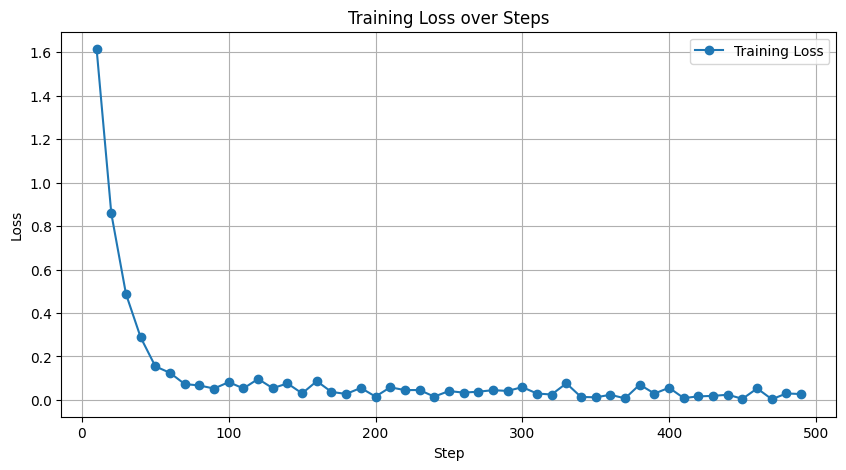

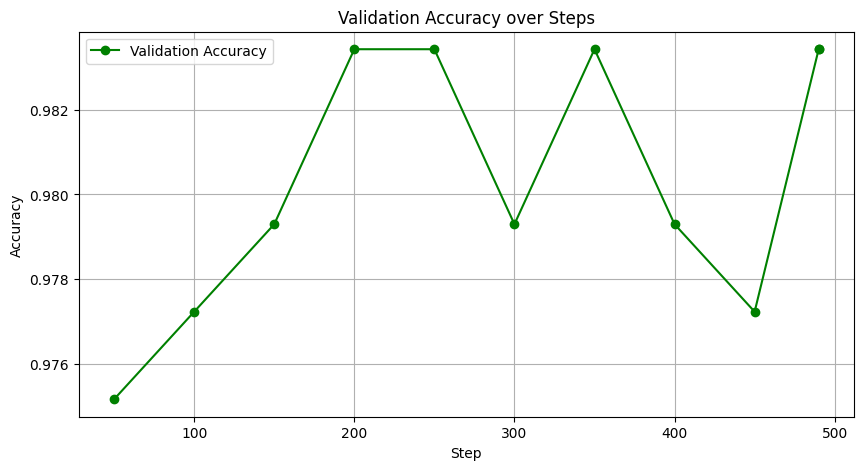

In [202]:
import matplotlib.pyplot as plt
from transformers import Trainer

# נניח שיש לך את האובייקט trainer אחרי האימון
logs = trainer.state.log_history

# נפריד את הנתונים
steps = [log["step"] for log in logs if "loss" in log]
train_loss = [log["loss"] for log in logs if "loss" in log]

val_steps = [log["step"] for log in logs if "eval_accuracy" in log]
val_accuracy = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]

# גרף 1 – Training Loss
plt.figure(figsize=(10,5))
plt.plot(steps, train_loss, label="Training Loss", marker="o")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.legend()
plt.show()

# גרף 2 – Validation Accuracy
plt.figure(figsize=(10,5))
plt.plot(val_steps, val_accuracy, label="Validation Accuracy", color="green", marker="o")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Steps")
plt.grid(True)
plt.legend()
plt.show()

In [203]:
from seqeval.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions)
    }

In [204]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.08953717350959778, 'eval_accuracy': 0.9834368530020704, 'eval_precision': 0.9468085106382979, 'eval_recall': 0.9468085106382979, 'eval_f1': 0.9468085106382979, 'eval_runtime': 0.4886, 'eval_samples_per_second': 88.001, 'eval_steps_per_second': 12.279, 'epoch': 10.0}


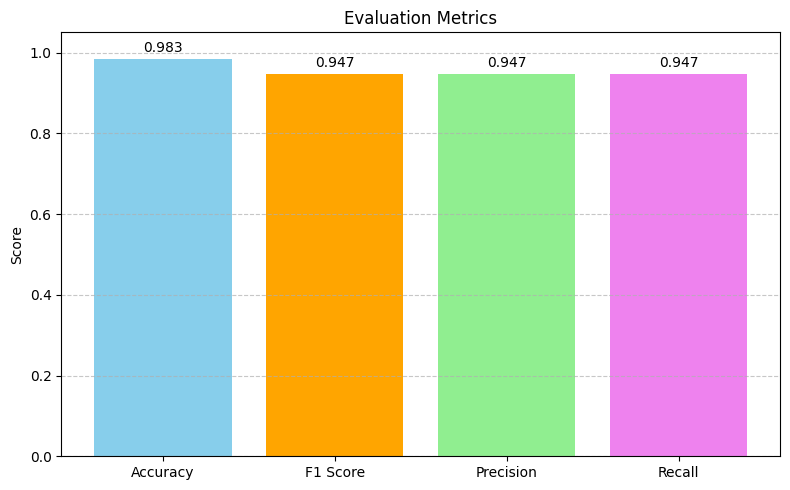

In [199]:
results = trainer.evaluate()

# נבחר רק את המדדים שאנחנו רוצות להציג
metrics_to_plot = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
metric_labels = ["Accuracy", "F1 Score", "Precision", "Recall"]
values = [results[m] for m in metrics_to_plot]

# ציור גרף
plt.figure(figsize=(8, 5))
bars = plt.bar(metric_labels, values, color=["skyblue", "orange", "lightgreen", "violet"])
plt.ylim(0, 1.05)
plt.title("Evaluation Metrics")
plt.ylabel("Score")

# הצגת ערכים על כל עמודה
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.3f}", ha="center", va="bottom")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Testing the model

In [209]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline


model_path = "./ner_model_roberta"
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForTokenClassification.from_pretrained(model_path)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

text = "how many bombs where droped on tel aviv this week?"

results = ner_pipeline(text)

print("📍 Entities detected:")
for entity in results:
    # print(f"🔸 {entity['word']} → {entity['entity_group']} (score: {entity['score']:.3f})")
    print(entity)

Device set to use cpu


📍 Entities detected:
{'entity_group': 'ALERT_TYPE', 'score': np.float32(0.99389267), 'word': ' bombs', 'start': 9, 'end': 14}
{'entity_group': 'LOCATION', 'score': np.float32(0.99016166), 'word': ' tel aviv', 'start': 31, 'end': 39}
{'entity_group': 'TIME_FRAME', 'score': np.float32(0.9949243), 'word': ' this week', 'start': 40, 'end': 49}


In [ ]:
def merge_subwords(ner_results):
    merged_entities = []
    current_entity = None

    sub_words_count = 1
    for entity in ner_results:
        if current_entity and entity["entity_group"] == current_entity["entity_group"]:
            if entity["start"] == current_entity["end"]:  
                current_entity["word"] += entity["word"]
            else:
                current_entity["score"] = current_entity["score"] / sub_words_count
                sub_words_count = 1
                merged_entities.append(current_entity)
                current_entity = entity.copy()

            current_entity["end"] = entity["end"]  # Update end position
            current_entity["score"] = (current_entity["score"] + entity["score"])
            sub_words_count += 1
        else:
            if current_entity:
                merged_entities.append(current_entity)
            current_entity = entity.copy()
    if current_entity:
        merged_entities.append(current_entity)

    return merged_entities